在讨论贝叶斯优化前，我们需要知道贝叶斯优化是来解决什么问题的。
一般来说，贝叶斯优化尝试做的事情就是尽快的找到给定的函数的最优解。通常这个函数是一个黑盒函数，也就是说这个函数没有一般的解析解，我们只能通过观察给定的输入和黑盒函数返回的输出来尝试这个函数的某些特征。一个典型的例子就是神经网络中的超参数调优.假设我们想在一个大型数据集上训练一个神经网络，但我们不确定这个神经网络应该有多少层。我们知道神经网络的架构在深度学习（DL）中是一个决定性因素，所以我们进行了一些初步测试，并获得了表格中所示的结果。
|  Number of layers  | Accuracy on the test set |
| -----| ---- |
|  5  | 0.72  |
| 10  | 0.21  |
| 15  | 0.75  |

我们的任务是决定在下一次试验中神经网络应具有多少层，以寻找最高的准确率。我们很难决定下一个应尝试哪个数字。我们找到的最佳准确率是 81%，这已经很好，但我们认为通过不同的层数可以做得更好。但是由于各种原因完成模型实现的DDL只有不到两个星期。由于在我们的大数据集上训练神经网络需要几天时间，我们只能通过剩下少数几次试验，来决定我们的网络应该有多少层。这个任务是寻找我们模型的最佳设置（超参数值），以优化某些性能指标，例如预测准确率，这通常在机器学习中被称为超参数调优。在我们的例子中，神经网络的超参数是其深度（层数）。如果我们使用决策树，常见的超参数包括最大深度、每个节点的最小点数和分裂标准。对于支持向量机，我们可以调整正则化项和核函数。由于模型的性能在很大程度上依赖于其超参数，因此超参数调优是任何机器学习流程中的一个重要组成部分。
如果这是一组典型的现实世界数据集，这个过程可能会耗费大量的时间和资源。而随着神经网络不断变得更大更深，所需的计算量（以 petaflop/s-天为单位）呈指数级增长。这意味着在大型数据集上训练模型是相当复杂的，并且需要付出大量的资源。此外，我们希望确定可以提供最佳准确性的超参数值，因此需要进行多次训练。我们应如何选择用于参数化模型的值，以便尽快找到最佳组合？这就是超参数调整的核心问题。
而在其他领域也有类似的黑箱优化的问题，如药物发现、找到合金的最低温度与采矿和石油钻探，或者更具体地说，是在一个大区域内找到具有最高产量的贵重矿物或石油的区域。

黑箱优化的成本十分高昂，我们现在介绍贝叶斯优化作为解决方案。我们先给贝叶斯优化一个定义:
*贝叶斯优化（BayesOpt）是一种机器学习技术，它同时维持一个预测模型来了解目标函数，并根据贝叶斯概率和决策理论，决定如何获取新数据以完善我们对目标的了解。*
我们所说的数据指的是黑盒函数的一个输入-输出对，每对都将一个输入值映射到该输入的目标函数值。在超参数调整的具体情况下，这些数据不同于我们要调整的机器学习模型的训练数据。
在贝叶斯优化程序中，我们根据贝叶斯优化算法的建议来做出决策。一旦我们采取了贝叶斯优化建议的行动，贝叶斯优化模型会根据该行动的结果进行更新，并继续推荐下一步的行动。这个过程会重复进行，直到我们确信已经找到了最佳行动。

这一工作流程有两个主要组成部分：
1. 一个机器学习模型，通过从我们做出的观察中学习，并对未见数据点上的目标函数值进行预测
2. 评估目标以确定最佳观测点的优化策略

BayesOpt的工作原理是首先在我们试图优化的目标函数上拟合一个预测机器学习模型——有时称之为代理模型，因为它在我们通过观察所认为的函数和实际函数之间充当代理。这个预测模型的作用非常重要，因为它的预测指导了BayesOpt算法做出的决策，从而直接影响优化性能。
在几乎所有情况下，高斯过程（GP）用于预测模型的角色。
为什么要用高斯过程呢，主要有以下几个原因：
1. 非参数性质： 高斯过程是非参数模型，它不假设数据具有特定的形式（如线性关系），而是通过训练数据自动学习数据之间的相关性。这使得它非常灵活，能够适应不同形式的目标函数，同时也能表现出更好的预测能力。
2. 不确定性度量： 高斯过程不仅能够给出对目标函数的预测，还能提供预测的不确定性。这对于贝叶斯优化非常重要，因为优化过程依赖于利用这些不确定性来平衡探索（exploration）和利用（exploitation）。在贝叶斯优化中，通常使用期望改进（EI）、概率改进（PI）或置信上限（UCB）等采集函数，而这些采集函数都依赖于高斯过程提供的不确定性信息。
3. 核函数的灵活性： 高斯过程可以通过选择不同的核函数（如线性核、RBF核、马氏核等）来适应不同的目标函数形式。这种灵活性使得高斯过程能够适应各种不同的优化问题。
4. 闭合解和计算便利性：高斯过程在数学上具有闭合解，特别是在计算后验分布时。这意味着在给定观测数据后，可以直接计算出目标函数的后验分布，而不需要进行复杂的数值积分或采样。
5. 平滑性假设：高斯过程天然假设目标函数是平滑的，即相近输入的输出值也相近。这个假设在许多优化问题中是合理的，而泊松过程等其他过程更适用于离散事件或突变情况，不适合描述连续平滑的函数。
总结一下：高斯函数能够很好地通过提供的参数获得一个数学上性质良好的（方便计算，平滑的，非参数性质）的模型，同时由于高斯过程先天能够提供预测的不确定性，这是的我们可以利用这些不确定性来更好的对模型进行采样。

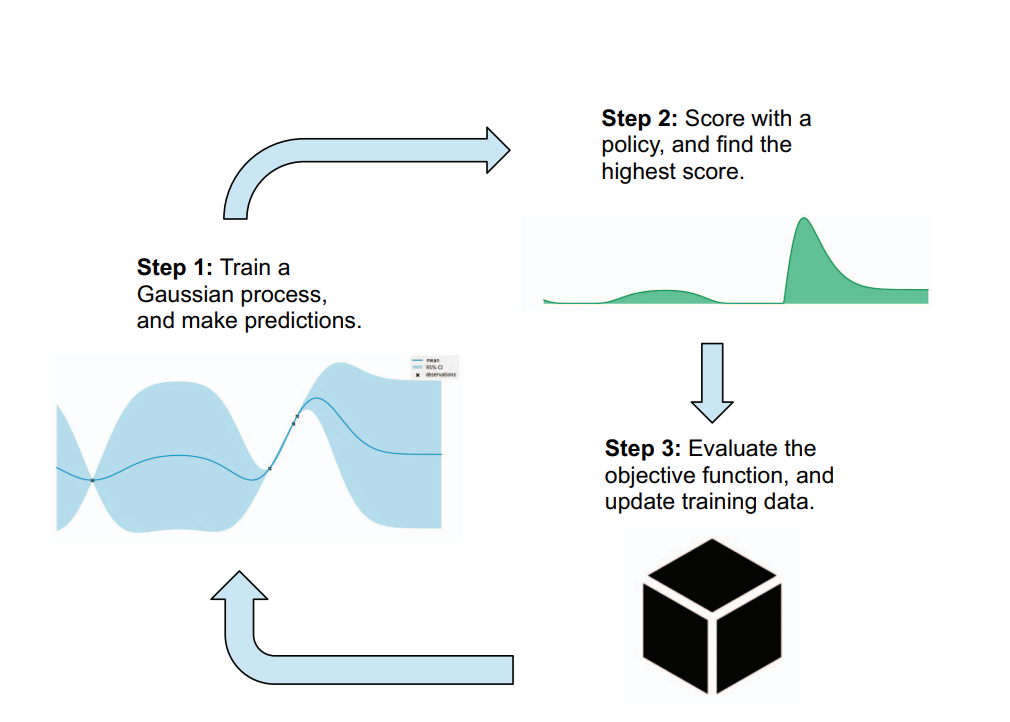
上面这张图展示了贝叶斯优化的基本流程，即
第一步：利用已有的数据，训练一个高斯过程模型同时做出对模型的预测（主动学习）
第二步：根据得到的预测，利用不同的方法对模型的每个点进行评分，选择出下一个需要得到输出的点。
第三步：把步骤二得到的数据带入到目标函数中，得到新的一对输入输出，更新数据并回到第一步。

我们下面先来看一个最基本的高斯过程回归模型（第一步）

In [1]:
import torch
import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm
# 生成从-5到5的101个等间隔点，并增加一个维度
xs = torch.linspace(-5, 5, 101).unsqueeze(1)

# 定义训练数据的输入和输出
train_x = torch.tensor([[0.5], [1.0], [1.5], [3], [4]])
train_y = torch.tensor([0.0625, 0.25, 3.75, 2.25, 4])

In [2]:
def visualize_gp_belief(model, likelihood, forrester_1d=False):
    """
    Visualizes the belief of a Gaussian Process model.

    Args:
        model (torch.nn.Module): The Gaussian Process model.
        likelihood (gpytorch.likelihoods.Likelihood): The likelihood function.

    Returns:
        None
    """
    with torch.no_grad():
        # 计算预测分布
        predictive_distribution = likelihood(model(xs))
        # 获取预测均值
        predictive_mean = predictive_distribution.mean
        # 获取95%置信区间的上下界
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    # 创建图形并设置大小
    plt.figure(figsize=(8, 6))

    if forrester_1d:
        # 绘制Forrester函数
        plt.plot(xs, forrester_1d(xs), label="Forrester function", c="r")
    # 绘制训练数据的散点图
    plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    # 绘制预测均值曲线
    plt.plot(xs, predictive_mean, label="mean", c="b")
    # 绘制95%置信区间
    plt.fill_between(xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI")

    # 显示图例并设置字体大小
    plt.legend(fontsize=15)

In [3]:
class ConstantMeanGPModel(gpytorch.models.ExactGP):
    """
    A Gaussian Process model with a constant mean function and an RBF kernel.
    Args:
        train_x (torch.Tensor): The training input data.
        train_y (torch.Tensor): The training target data.
        likelihood (gpytorch.likelihoods.Likelihood): The likelihood function.

    Attributes:
        mean_module (gpytorch.means.ConstantMean): The constant mean module.
        covar_module (gpytorch.kernels.RBFKernel): The RBF kernel module.
    """

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # constant mean function
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        """
        Forward pass of the Gaussian Process model.

        Args:
            x (torch.Tensor): The input data.

        Returns:
            gpytorch.distributions.MultivariateNormal: The predicted distribution.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

我们通过几个点就能确定一个高斯过程。图中的蓝线是高斯过程的均值，想象高斯过程是由无限多个高斯分布叠加而来的，对于一个没有观察到的x（变量），我们预测它的f(x)符合一个高斯分布，高斯分布的均值就是图上纵轴上的值，高斯分布的方差没有在图中直接表示，取而代之的是一个95%的置信区间(浅蓝色部分)，即f(x)有95%的几率掉落在浅蓝色部分之间。
换句话说，高斯过程是高斯分布在函数空间的推广，经典的高斯分布由一个均值向量和协方差矩阵刻画，即$X \sim \mathcal{N}(\mu, \sigma^2)$,高斯过程将这个概念推广到函数空间，认为任何有限数量的输入点对应的函数值服从一个多元高斯分布。在这个情况下，均值向量决定了分布的中心位置，而协方差矩阵则决定了各个变量之间的相关性和分布的形状。
换句话说，高斯过程假设任何函数值的集合 $(f(x_1),f(x_2),…,f(x_n))$ 服从一个多元高斯分布，其分布由均值向量和协方差矩阵完全刻画。
协方差函数定义了输入点之间的相似性，即输入点越相似，它们的输出值越相关。协方差函数决定了GP的平滑性、周期性、幅度等性质。
高斯过程的均值函数定义了在没有数据时，模型预测的默认值。换句话说，它表示的是GP在每个输入点的平均预测值。
而随着x的增大，同时没有已知的观测点，高斯过程会逐渐回归到最开始的状态。

In [4]:
def forrester_1d(x):
    """
    Calculates the value of the Forrester function in 1D.

    Parameters:
    - x: Input value.

    Returns:
    - y: Output value calculated using the Forrester function.
    """
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)
# 设置随机种子

torch.manual_seed(0)
# 生成训练数据的输入，范围在[-3, 3]之间
train_x = torch.rand(size=(3, 1)) * 6 - 3
# 使用Forrester函数计算训练数据的输出
train_y = forrester_1d(train_x)
# 输出训练数据的输入和输出
train_x, train_y

(tensor([[-0.0225],
         [ 1.6093],
         [-2.4691]]),
 tensor([0.8228, 2.1909, 1.0872]))

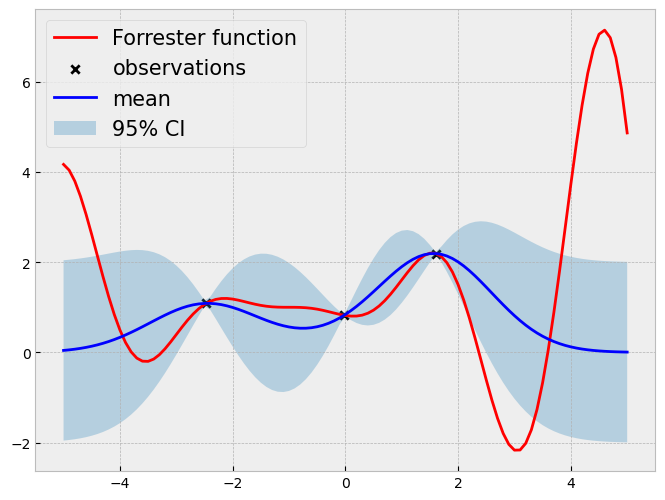

In [5]:
# 声明高斯过程（GP）
lengthscale = 1  # 设置长度尺度参数
noise = 1e-4  # 设置噪声参数

# 定义高斯似然函数
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# 创建常数均值GP模型
model = ConstantMeanGPModel(train_x, train_y, likelihood)

# 固定超参数
model.covar_module.lengthscale = lengthscale  # 设置协方差模块的长度尺度
model.likelihood.noise = noise  # 设置似然函数的噪声

# 将模型和似然函数设置为求值模式
model.eval()
likelihood.eval()

# 可视化GP的置信区间
visualize_gp_belief(model, likelihood, forrester_1d)

我们可以看到高斯过程对于目标函数局部的回归还是比较好的。而想要找到目标函数的全局最优解，我们就需要下面两步，即选择下一个需要求值的点以及再次训练模型。而找到下一个点的方法决定了这个模型是留在局部最优中还是会去更激进的探索位置的点，进而决定了它能否找到最优解。
这种选择主要是在探索与利用两种策略间进行权衡，而具体的实现我们称之为采集函数。

In [6]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    """
    Visualizes the Gaussian Process (GP) belief and policy.
    Args:
        model (torch.nn.Module): The GP model.
        likelihood (gpytorch.likelihoods.Likelihood): The likelihood function.
        policy (torch.nn.Module, optional): The policy function. Defaults to None.
        next_x (torch.Tensor, optional): The next x value. Defaults to None.
    """
    # Rest of the code...
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

上面是一个可视化函数，具体细节不用特别关心

In [7]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def fit_gp_model(train_x, train_y, num_train_iters=500):
    """
    Fits a Gaussian Process (GP) model to the given training data.

    Parameters:
    - train_x (torch.Tensor): The input training data.
    - train_y (torch.Tensor): The target training data.
    - num_train_iters (int): The number of training iterations (default: 500).

    Returns:
    - model (GPModel): The trained GP model.
    - likelihood (GaussianLikelihood): The likelihood function associated with the GP model.
    """
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

这一步的目的是拟合高斯过程

In [8]:
# 设置边界值
bound = 5

# 生成从-bound到bound的等间隔点，并增加一个维度
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
# 使用Forrester函数计算这些点的输出
ys = forrester_1d(xs)

# 设置随机种子
torch.manual_seed(2)
# 生成训练数据的输入，范围在[-bound, bound]之间
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
# 使用Forrester函数计算训练数据的输出
train_y = forrester_1d(train_x)

In [9]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

model, likelihood = fit_gp_model(train_x, train_y)

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 设置查询次数
num_queries = 5

# 进行贝叶斯优化循环
for i in range(num_queries):
    # 打印当前迭代次数
    print("iteration", i)
    # 打印当前最优解（incumbent）
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    # 拟合高斯过程模型
    model, likelihood = fit_gp_model(train_x, train_y)

    # 定义改进概率（Probability of Improvement）策略
    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    # 优化获取函数以找到下一个查询点
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    # 可视化高斯过程的置信区间和策略
    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    # 使用Forrester函数计算下一个查询点的输出
    next_y = forrester_1d(next_x)

    # 将新的查询点和输出添加到训练数据中
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

: 

从上面的图中我们可以看到使用改进概率（Probability of Improvement）的选点是比较保守的，它会优先去找到局部最优解，而更少的去探索

In [ ]:
# 设置查询次数
num_queries = 5

# 进行贝叶斯优化循环
for i in range(num_queries):
    # 打印当前迭代次数
    print("iteration", i)
    # 打印当前最优解（incumbent）
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    # 拟合高斯过程模型
    model, likelihood = fit_gp_model(train_x, train_y)

    # 定义期望改进概率（Expected of Improvement）策略
    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=train_y.max()
    )
    
    # 优化获取函数以找到下一个查询点
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    # 可视化高斯过程的置信区间和策略
    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    # 使用Forrester函数计算下一个查询点的输出
    next_y = forrester_1d(next_x)

    # 将新的查询点和输出添加到训练数据中
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

: 

我们可以看到期望改进（EI）和PI最大的一个不同在与在局部最优解找完后，EI倾向与找尚未探索的点。这和他们的数学实现方式有关。
PI的目标是最大化目标函数值超越当前最优值的概率，而EI的目标是最大化目标函数值相较于当前最优值的期望改进。详细的数学过程放在下面的链接里。
采集函数除了上面提到的这两种，还有UCB（Upper Confidence Bound）（对均值和方差进行加权平衡）,最大熵估计( Max-value entropy search)(找到能获取最多信息的点)等等方法。
总结起来，各种算法总是在探索和利用之间进行权衡，而实际应用我们可以利用多线程等方法利用各种方法来找到全局的一个最优解。

PS:
1. 概率论和统计学基础
2. 贝叶斯推断基础（https://e2eml.school/how_bayesian_inference_works.html）
3. 高斯过程回归（https://zhuanlan.zhihu.com/p/331591492），白板机器学习高斯过程
4. [采样函数](https://www.zhihu.com/question/513917730/answer/2492820967)


: 